Machine learning potential in `OpenMM`
--------------------------------------

Warm-up exercises:
- Read about one of the most widely used machine learning potentials, [ANI](https://arxiv.org/abs/1610.08935)
- Summarize in a few sentences what are the advantages and limitations of MM simulations.

We have previously shown how to use OpenMM to run molecular dynamics (MD) simulations
with [molecular mechanics (MM)](https://en.wikipedia.org/wiki/Molecular_mechanics) force fields.

Despite remarkable speed ⚡️, MM oversimplifies the interactions among molecules as
low-order Fourier series, and harmonic and pairwise terms, and might not be accurate enough
on high energy region.

![MM](mm.png)

In this notebook, we replace the traditional MM in `OpenMM` with the popular
[machine learning potential](https://en.wikipedia.org/wiki/Machine_learning_potential) 
that have been rapidly developed in recent years.

First, we need to intall the `openmmml` package using `conda install -c conda-forge openmm-ml` to complement the `OpenMM` package with
ML potential functionality.

### First simulation with OpenMM-ML

In [35]:
import openmm
from openmm import app, unit
from openmmml import MLPotential

The [PDB](https://www.rcsb.org) loading stage is identical to the original `OpenMM` procedure.
Here we again load the good old alanine dipeptide example. 

In [36]:
import urllib
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/openmm/openmm/master/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb",
    "input.pdb"
)
pdb = app.PDBFile('input.pdb')

In [37]:
from openmm.app import Modeller
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()

In lieu of a (MM) foce field, we here specify a machine learning potential.

In [38]:
potential = MLPotential('ani2x')

The creation of the system is again very similar to MM.
Note that here we don't need to specify specific solvent model etc. since the entire system
is treated without distinction by the ML potential.
In other words, the machine learning potential only sees a point cloud, without
paying attention to which part is solvent, protein, or ligand.

In [39]:
system = potential.createSystem(modeller.topology)

/Users/yuanqingwang/miniconda3/envs/openmm/lib/python3.11/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Now, to construct an integrator and a simulation is just like before.

In [40]:
#NOTE:HIDDEN
integrator = openmm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds,
)

In [41]:
#NOTE:HIDDEN
simulation = app.Simulation(modeller.topology, system, integrator)

And just like before, you can easily set the positions
and minimize the energy.

In [43]:
#NOTE:HIDDEN
simulation.context.setPositions(modeller.positions)

In [44]:
simulation.minimizeEnergy()

Again, we employ a _Reporter_ object to record the simulation.

In [32]:
simulation.reporters.append(app.PDBReporter('output.pdb', 10))

We can now run the simulation.

In [45]:
simulation.step(100)

You can see that the time required to run this simulation (even without explicit water) is significantly longer than with traditional MM force fields.
Can you time it?

### Trade-off between accuracy and speed

To quantitatively compare the trade-off between accuracy and speed,
we first grab some quantum chemical calculation for ethanol, my favorite molecule,
for reference.

In [48]:
urllib.request.urlretrieve(
    "http://www.quantum-machine.org/gdml/data/npz/ethanol_ccsd_t.zip",
    "ethanol_ccsd_t.zip"
)
import shutil
shutil.unpack_archive("ethanol_ccsd_t.zip", "ethanol_ccsd_t")

('ethanol_ccsd_t.zip', <http.client.HTTPMessage at 0x1685bf890>)

In [52]:
import numpy as np
data = np.load('ethanol_ccsd_t/ethanol_ccsd_t-test.npz')

We then construct a `openff.toolkit.Molecule` object:

In [119]:
#NOTE:HIDDEN
from openff.toolkit import Molecule
molecule = Molecule.from_smiles('CCO')

The conformations from the QM trajectory are assigned to the molecule's conformers.

In [120]:
for idx in range(len(data["R"])):
    molecule.add_conformer(
        data["R"][idx] * unit.angstrom
    )

We then create a `system_mm` and a `system_ml` object based on different force fields.

In [125]:
#NOTE:HIDDEN
from openff.toolkit.typing.engines.smirnoff import ForceField
forcefield = ForceField('openff-1.0.0.offxml')
potential = MLPotential('ani2x')
system_mm = forcefield.create_openmm_system(molecule.to_topology())
system_ml = potential.createSystem(molecule.to_topology().to_openmm())

/Users/yuanqingwang/miniconda3/envs/openmm/lib/python3.11/site-packages/openff/interchange/smirnoff/_create.py:145: UserWarning: Automatically up-converting BondHandler from version 0.3 to 0.4. Consider manually upgrading this BondHandler (or <Bonds> section in an OFFXML file) to 0.4 or newer. For more details, see https://openforcefield.github.io/standards/standards/smirnoff/#bonds.
  _upconvert_bondhandler(force_field["Bonds"])


/Users/yuanqingwang/miniconda3/envs/openmm/lib/python3.11/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Now we write a functino to evaluate the energies using either force field with the
conformers.

In [126]:
#NOTE:HIDDEN
def get_energies(system):
    energies = []
    integrator = openmm.LangevinIntegrator(
        300*unit.kelvin, 
        1.0/unit.picoseconds, 
        2.0*unit.femtoseconds,
    )
    simulation = app.Simulation(molecule.to_topology(), system, integrator)
    for idx in range(len(molecule.conformers)):
        molecule.conformers[idx]
        simulation.context.setPositions(
            openmm.unit.angstrom * molecule._conformers[idx].magnitude
        )
        energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
        energies.append(energy._value)
    return energies

Can you time it when evaluating the energies as well?

In [135]:
#NOTE:HIDDEN
energies_ml = get_energies(system_ml)

In [136]:
#NOTE:HIDDEN
energies_mm = get_energies(system_mm)

Now, we show the correlation between MM and QM and ML and QM.

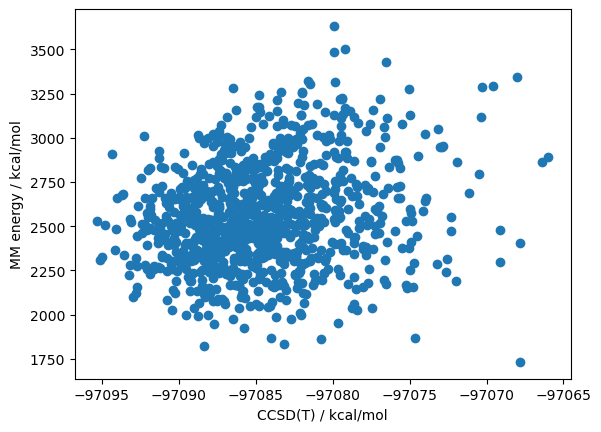

In [133]:
plt.scatter(
    data["E"], 
    energies_mm,
)
plt.xlabel("CCSD(T) / kcal/mol")
plt.ylabel("MM energy / kcal/mol")
plt.show()

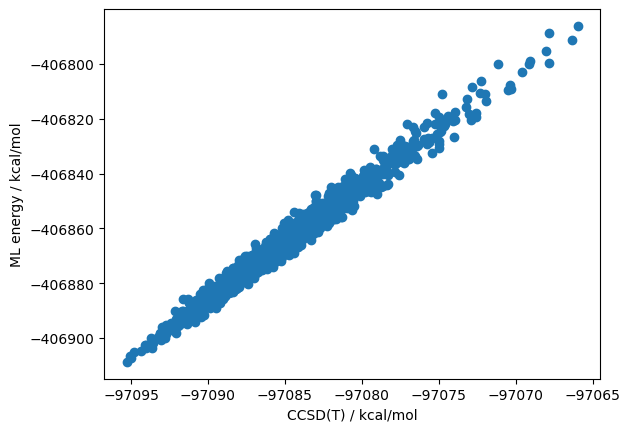

In [134]:
plt.scatter(
    data["E"], 
    energies_ml,
)
plt.xlabel("CCSD(T) / kcal/mol")
plt.ylabel("ML energy / kcal/mol")
plt.show()

Note that the offset is not important in real simulations.

I guess you can now understand the reason behind ML force fields!

### Exercises
- Try a few systems of various sizes and observe how the time requirement scales with the size of the system.
And do the same for MM force fields.
- Try running this simulation with explicit water.